## **Imports**

In [1]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatPlotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

# import some necessary tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer

## Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


## Classification Metrics
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, 
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)

## Set global scikit-learn configuration 
from sklearn import set_config

## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

from IPython.core.display import clear_output

## **Functions**

In [2]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test, 
                       model_name='Regression Model'):
  
  """Takes a regression model, training features and target and testing 
  features and target.
  Returns a dataframe of regression metrics"""

  ## Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)
  
  metrics = ['train_MAE','test_MAE', 
             'train_RMSE', 'test_RMSE', 
             'train_R2', 'test_R2']
  
  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  ## Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[f'{model_name}'])
  scores.loc[f'{model_name}', :] = [train_mae, test_mae,
                                          train_rmse, test_rmse,
                                          train_r2, test_r2]

  return scores


  ## Classification Evaluation function
def eval_classification(model,X_train,X_test,y_train,y_test):
    """Uses model.score to display the accuracy scores for 
    training and test splits"""
    print(f"Training Accuracy: {model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {model.score(X_test, y_test):.3f}")

## **Data Set 1**

Source of data

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

Brief Description of Data

'Stroke Prediction Dataset' is a binary classification dataset which will be experimented with models.  We will use this dataset to demonstrate how to evaluate a classification model on a binary classification problem.  Each record in this dataset correlates to patients risk of strokes and each feature represents health factors of an individual.

Our task will be to create a model that predicts an individual's risk of stroke based on the their personal information.

## **Load the Data**

In [3]:
#Load the Data
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

### **Create a Copy of the Dataset**

In [4]:
backup_df = df.copy()

### **Inspect the Data**

In [5]:
# Display the first (5) rows of the dataframe
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


A row in this data set displays the health factors and other features which correlates to an individual's risk of stroke.

#### Check column names, shape, datatypes, and missing values

In [6]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 5110 rows, and 12 columns.
The rows represent 5110 observations, and the columns represent 11 features and 1 target variable.


In [7]:
## Display the column names, count of non-null values, and their datatypes
## Columns with mixed datatypes are identified as an object datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 201 missing values.


In [9]:
# Display the columns and sum of missing values
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

#### Check for unusual or impossible values

In [10]:
## Display the descriptive statistics for the numeric columns
df.describe(include="number") ## or 'object'

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
## Display the descriptive statistics for the non-numeric columns
df.describe(include="object") # or 'number'

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


#### Inspect Values for Errors

In [12]:
# Inspect categorical columns for errors
cat_cols = make_column_selector(dtype_include='object')(df)
for col in cat_cols:
  display(df[col].value_counts(normalize=True))

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64

Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64

Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64

never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64

Some challenges one may foresee while cleaning, exploring and modeling this dataset can be the following:


*   Data Leakage
*   Duplicated, Inconsistent, and/or Missing values

*   Class Imbalances
*   False Predictions and Sampling Errors

## **Clean the Data**

### Remove Unnecessary Rows

#### Duplicates

In [13]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### Remove Unnecessary Columns

In [14]:
# convert column names to lower case
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

- There are no columns to be dropped.

### Address Data Errors

#### Categorical

#### Numerical

## **Model Validation Data Split**

### Check Class Balance

In [15]:
# Check how many samples of each class are present
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

### Split the Data

In [16]:
## Define features (X) and target (y)
target = 'stroke'

X = df.drop(target, axis=1)
y = df[target]
X.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


The target in this data set is "stroke". 

The target is 0 = No Stroke,

or 1 = Stroke.

In [17]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Check Class Balance

In [18]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0    0.9512
1    0.0488
Name: stroke, dtype: float64

In [19]:
## Check how many samples of each class are present for test
y_test.value_counts(normalize=True)

0    0.951487
1    0.048513
Name: stroke, dtype: float64

## Preprocessing for Machine Learning

In [20]:
# Transformers
scaler = StandardScaler()
median_imputer = SimpleImputer(strategy='median')

#Pipeline
num_pipe = make_pipeline(median_imputer, scaler)

#Selector
num_selector = make_column_selector(dtype_include='number')

#Tuple
num_tuple = (num_pipe, num_selector)

In [21]:
# Transformers
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
freq_imputer = SimpleImputer(strategy='most_frequent', fill_value='missing')

#Pipeline
cat_pipe = make_pipeline(freq_imputer, ohe)

#Selector
cat_cols = make_column_selector(dtype_include='object')

#Tuple
cat_tuple = (cat_pipe, cat_cols)

In [22]:
## Create the preprocessor using make_column_transformer
preprocessor = make_column_transformer(num_tuple,
                                       cat_tuple,
                                       remainder='drop')

In [23]:
# fit on train
preprocessor.fit(X_train)

# Transforming train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Check for missing values and that data is scaled and one-hot encoded
display(X_train_processed)

array([[-0.14413791, -0.19109154, -0.32642765, ...,  0.        ,
         1.        ,  0.        ],
       [-0.11753355,  0.51793982, -0.32642765, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.62362817,  0.69519765, -0.32642765, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.20915835,  0.78382657, -0.32642765, ...,  1.        ,
         0.        ,  0.        ],
       [-1.53814052, -0.54560721, -0.32642765, ...,  0.        ,
         0.        ,  0.        ],
       [-0.21812247, -1.6534687 , -0.32642765, ...,  0.        ,
         0.        ,  0.        ]])

## **Modeling & Evaluating**

### Decision Tree Model

In [24]:
# Create a DecisionTreeClassifier on the adult income data
dt = DecisionTreeClassifier()
dt_pipe = make_pipeline(preprocessor, dt)

# Fit model on the training data
dt_pipe.fit(X_train, y_train)

#Save their predictions on the train test sets
dt_train_preds = dt_pipe.predict(X_train)
dt_test_preds = dt_pipe.predict(X_test)

In [25]:
# Evaluate the decision tree on the training data using classification_report()
# and a confusion matrix
print('Train Report')
print(classification_report(y_train, dt_train_preds))

Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       1.00      1.00      1.00       187

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832



In [26]:
# Evaluate the decision tree on the test data using classification_report()
# and a confusion matrix
print('Test Report')
print(classification_report(y_test, dt_test_preds))

Test Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1216
           1       0.18      0.23      0.20        62

    accuracy                           0.91      1278
   macro avg       0.57      0.59      0.58      1278
weighted avg       0.92      0.91      0.92      1278



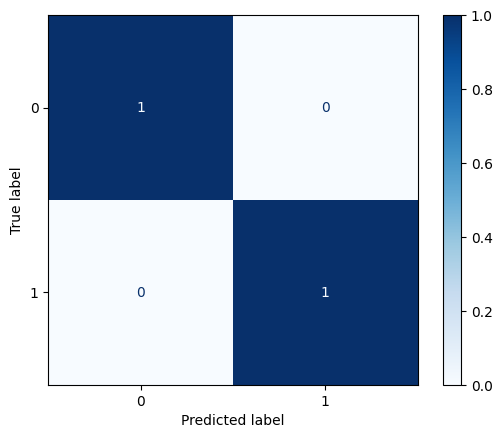

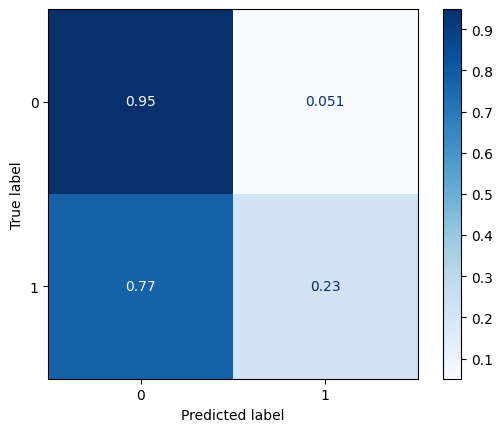

In [27]:
## Create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_train, dt_train_preds, 
               normalize='true', cmap='Blues')


ConfusionMatrixDisplay.from_predictions(y_test, dt_test_preds, 
               normalize='true', cmap='Blues')

## **Data Set 2**

Source

https://www.kaggle.com/datasets/wenruliu/adult-income-dataset

Brief Description of Data

'Adult Income' is a binary classification dataset which will experimented with models.  We will use this dataset to demonstrate how to evaluate a classification model on a binary classification problem.  Each record in this dataset correlates to adult income and each feature represents a demographic of an individual.

Our task will be to create a model that classifies income level based on the individual's personal information.

## **Load the Data**

In [28]:
#Load the Data
df2 = pd.read_csv('/content/adult.csv.zip')

A row in this data set displays the demographics and other features which correlates to an individual's income.

## **Create a Copy of the Dataset**

In [29]:
backup_df2 = df2.copy()

## **Inspect the Data**

In [30]:
# Display the first (5) rows of the dataframe
df2.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


#### Check column names, shape, datatypes, and missing values

In [31]:
# Display the number of rows and columns for the dataframe
df2.shape
print(f'There are {df2.shape[0]} rows, and {df2.shape[1]} columns.')
print(f'The rows represent {df2.shape[0]} observations, and the columns represent {df2.shape[1]-1} features and 1 target variable.')

There are 48842 rows, and 15 columns.
The rows represent 48842 observations, and the columns represent 14 features and 1 target variable.


In [32]:
# Display the column names, count of non-null values, and their datatypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [33]:
# Display the total number of missing values
print(f'There are {df2.isna().sum().sum()} missing values.')

There are 0 missing values.


- If there are no missing values we will not need to impute any. 
 - We will not need to use SimpleImputer in our preprocessing steps.

- **Never use fillna() to impute values prior to Train_Test_Split, as it would cause data leakage.**

#### Check for unusual or impossible values

In [34]:
## Display the descriptive statistics for the numeric columns
df.describe(include="number") ## or 'object'

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [35]:
## Display the descriptive statistics for the non-numeric columns
df.describe(include="object") # or 'number'

,gender,ever_married,work_type,residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


#### Inspect Values for Errors

In [36]:
# Inspect categorical columns for errors
cat_cols = make_column_selector(dtype_include='object')(df)
for col in cat_cols:
  display(df[col].value_counts(normalize=True))

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64

Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64

Urban    0.508023
Rural    0.491977
Name: residence_type, dtype: float64

never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64

Some challenges one may foresee while cleaning, exploring and modeling this dataset can be the following:


*   Data Leakage
*   Duplicated, Inconsistent and/or Missing values

*   Class Imbalances
*   False Predictions and Sampling Errors





## **Clean the Data**

### Remove Unnecessary Rows

#### Duplicates

In [37]:
# Display the number of duplicate rows in the dataset
print(f'There are {df2.duplicated().sum()} duplicate rows.')

There are 52 duplicate rows.


In [38]:
# Drop duplicate rows
df2.drop_duplicates(inplace=True)

In [39]:
# Confirm now duplicate rows remain
df2.duplicated().sum()

0

### Remove Unnecessary Columns

In [40]:
# convert column names to lower case
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### Address Data Errors

#### Categorical

Numerical

## **Model Validation Data Split**



### Check Class Balance

In [41]:
# Check how many samples of each class are present
df2['income'].value_counts(normalize = True)

<=50K    0.760586
>50K     0.239414
Name: income, dtype: float64

- Let's change 'income' to a binary value.

In [42]:
df2['income'] = df2['income'].replace({'<=50K':0, '>50K':1})

In [43]:
df2['income'].value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        0
2        1
3        1
4        0
        ..
48837    0
48838    1
48839    0
48840    0
48841    1
Name: income, Length: 48790, dtype: int64>

### Split the Data

In [44]:
## Define features (X) and target (y)
target = 'income'

X = df2.drop(target, axis=1)
y = df2[target]
X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


The target in this data set is "income". 

The target is 0 = Less than and/or equal to $50K,

or 1 = Greater than $50k.

In [45]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#### Check Class Balance

In [46]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0    0.760576
1    0.239424
Name: income, dtype: float64

In [47]:
# Check how many samples of each class are present for test
y_test.value_counts(normalize=True)

0    0.760616
1    0.239384
Name: income, dtype: float64

## **Preprocessing for Machine Learning**

In [48]:
# Transformers
scaler = StandardScaler()

#Pipeline
num_pipe = make_pipeline(scaler)

#Selector
num_selector = make_column_selector(dtype_include='number')

#Tuple
num_tuple = (num_pipe, num_selector)

In [49]:
# Transformers
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
freq_imputer = SimpleImputer(strategy='most_frequent', fill_value='missing')

#Pipeline
cat_pipe = make_pipeline(freq_imputer, ohe)

#Selector
cat_cols = make_column_selector(dtype_include='object')

#Tuple
cat_tuple = (cat_pipe, cat_cols)

In [50]:
## Create the preprocessor using make_column_transformer
preprocessor = make_column_transformer(num_tuple,
                                       cat_tuple,
                                       remainder='drop')

In [51]:
# fit on train
preprocessor.fit(X_train)

# Transforming train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Check for missing values and that data is scaled and one-hot encoded
display(X_train_processed)

array([[ 0.24448739,  0.07032513, -0.41949016, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.90202829,  0.39011735, -0.02983732, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.02530708, -0.94882885,  1.13912121, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 2.58241061, -0.6688819 , -0.41949016, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.46366769,  1.7045572 ,  1.13912121, ...,  1.        ,
         0.        ,  0.        ],
       [-0.19387322,  0.17441803, -1.97810154, ...,  1.        ,
         0.        ,  0.        ]])

## **Modeling and Evaluating**

### K-Nearest Neighbors Model

In [52]:
# Create an instance of the model
knn = KNeighborsClassifier()
# Create a model pipeline
knn_pipe = make_pipeline(preprocessor, knn)
# Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ec59de620>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ec59de740>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [53]:
# Save the model's predictions for the train dataset
train_preds = knn_pipe.predict(X_train)
# Save the model's predictions for the test dataset
test_preds = knn_pipe.predict(X_test)

In [54]:
train_knn_report = classification_report(y_train, train_preds)
test_knn_report = classification_report(y_test, test_preds)

In [55]:
# Classification Report for the Train dataset
# Save the Classification Report

print('Train\n', train_knn_report)

Train
               precision    recall  f1-score   support

           0       0.91      0.94      0.92     27831
           1       0.78      0.70      0.74      8761

    accuracy                           0.88     36592
   macro avg       0.85      0.82      0.83     36592
weighted avg       0.88      0.88      0.88     36592



In [56]:
# Classification Report for the Test dataset
# Save the Classification Report


print('Test\n', test_knn_report)

Test
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      9278
           1       0.68      0.60      0.64      2920

    accuracy                           0.84     12198
   macro avg       0.78      0.76      0.77     12198
weighted avg       0.83      0.84      0.83     12198



Text(0.5, 1.0, 'Test CM')

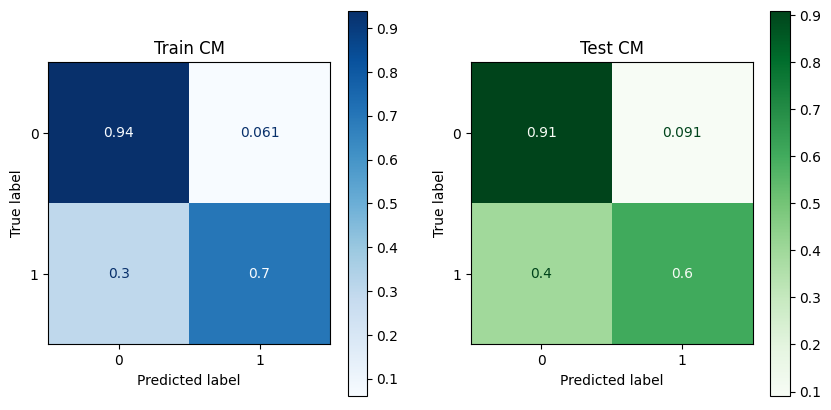

In [57]:
# Display the test and training Confusion Matrix
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

ConfusionMatrixDisplay.from_predictions(y_train, train_preds,
                                        ax=axes[0], cmap='Blues',
                                        normalize='true')

axes[0].set_title('Train CM')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,
                                        ax=axes[1], cmap='Greens',
                                        normalize='true')

axes[1].set_title('Test CM')

### **Tune the Hyperparameters**

In [58]:
# Display the hyperparameters.
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ec59de620>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    <sklearn.compose._column_transformer.ma

In [59]:
# Create a dictionary of parameters

params = {'kneighborsclassifier__n_neighbors': range(1,20),
          'kneighborsclassifier__weights': ['distance','uniform']}

In [60]:
# Tune hyperparameters with GridSearchCV
knn_gs = GridSearchCV(knn_pipe, params)
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ec59de620>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ec59de740>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 20),
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']})

In [61]:
knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 19,
 'kneighborsclassifier__weights': 'uniform'}

In [62]:
knn_gs.best_score_

0.8416595777906389

In [63]:
best_knn = knn_gs.best_estimator_

In [64]:
#check the best parameter
# Instantiate and fit GridSearchCV
train_preds = best_knn.predict(X_train)
test_preds = best_knn.predict(X_test)

In [65]:
print('Train\n', classification_report(y_train, train_preds))
print('Test\n', classification_report(y_test, test_preds))

Train
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     27831
           1       0.73      0.63      0.68      8761

    accuracy                           0.86     36592
   macro avg       0.81      0.78      0.79     36592
weighted avg       0.85      0.86      0.85     36592

Test
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      9278
           1       0.70      0.60      0.65      2920

    accuracy                           0.84     12198
   macro avg       0.79      0.76      0.77     12198
weighted avg       0.84      0.84      0.84     12198



Text(0.5, 1.0, 'Test CM')

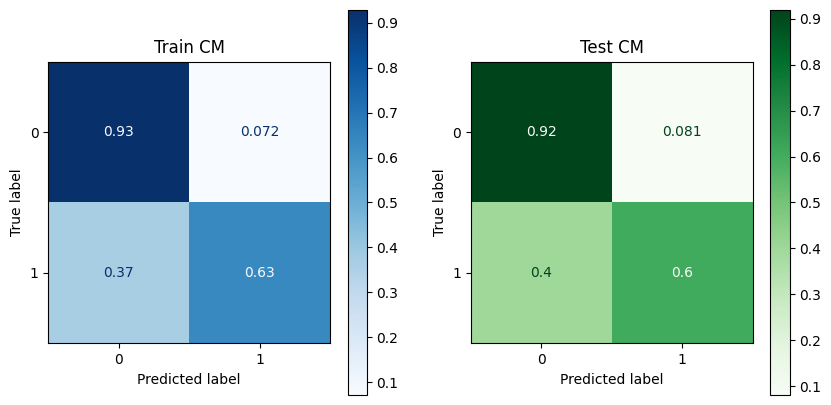

In [66]:
# Check the class balance again to help us choose a metric
# Display the test and training Confusion Matrix
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

ConfusionMatrixDisplay.from_predictions(y_train, train_preds,
                                        ax=axes[0], cmap='Blues',normalize='true')

axes[0].set_title('Train CM')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,
                                        ax=axes[1], cmap='Greens',normalize='true')

axes[1].set_title('Test CM')